# LightGBM Model

Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

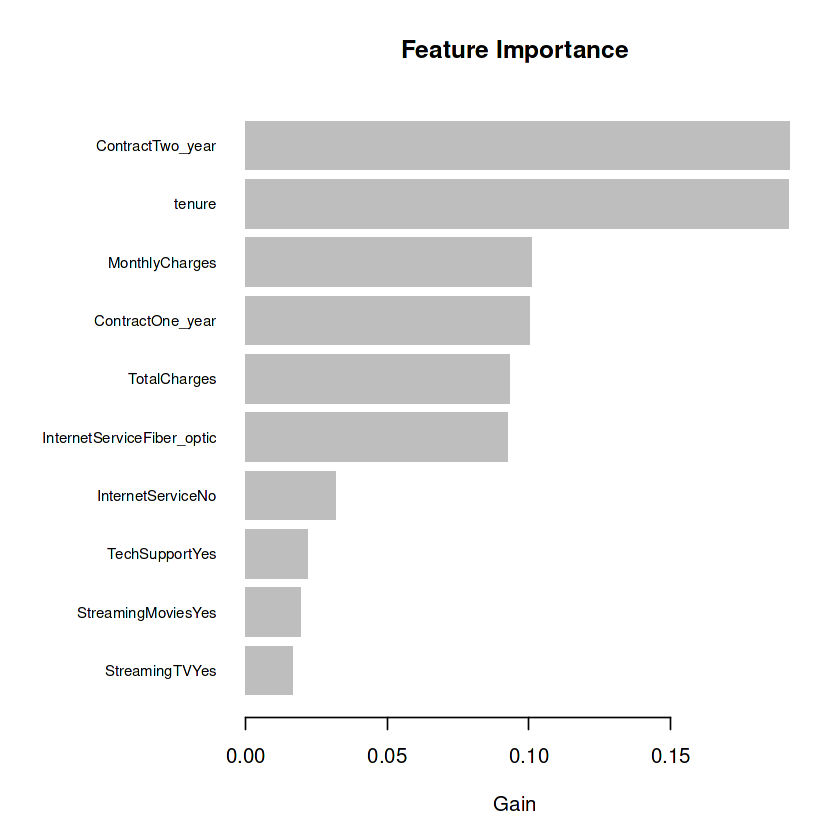


AUC: 0.836163 

Performance Metrics:
             Metric     Value
Accuracy   Accuracy 0.7384506
Precision Precision 0.5043937
Recall       Recall 0.7694370
F1               F1 0.6093418
                AUC 0.8361630


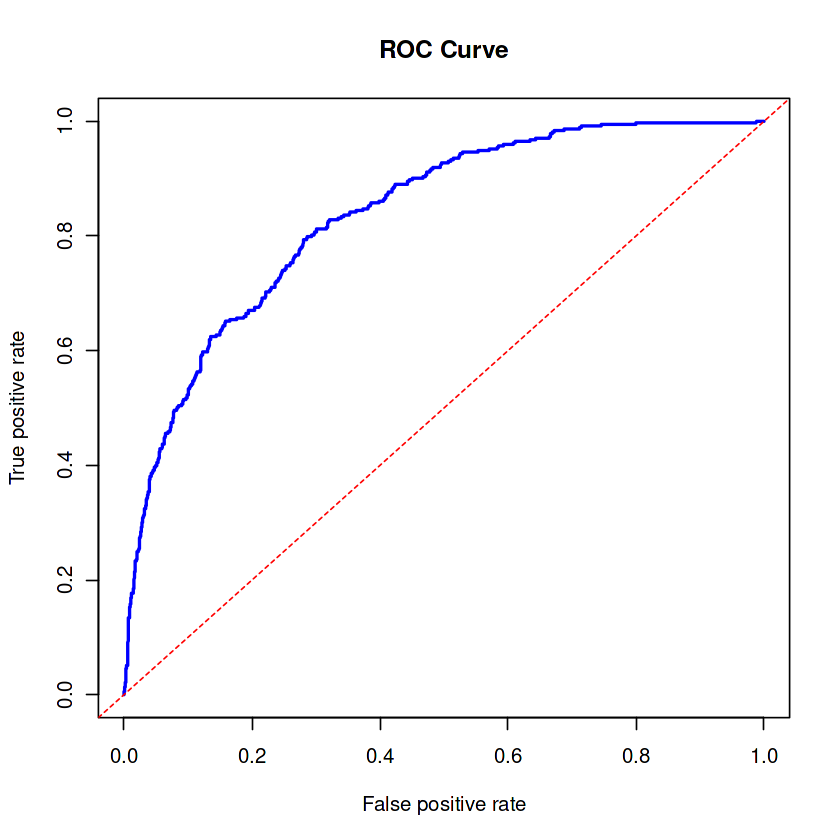

In [3]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, lightgbm, skimr, ggplot2, DataExplorer, ROCR, Matrix)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

## ----------------------------
## LightGBM Implementation
## ----------------------------

# Prepare data for LightGBM
train_labels <- as.numeric(train_data$Churn) - 1  # No=0, Yes=1
test_labels <- as.numeric(test_data$Churn) - 1

# One-hot encode categorical variables
dtrain <- sparse.model.matrix(Churn ~ . - 1, data = train_data)
dtest <- sparse.model.matrix(Churn ~ . - 1, data = test_data)

cat("\nModel matrix dimensions:\n")
cat("Training:", dim(dtrain), "\n")
cat("Testing:", dim(dtest), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == 0) / sum(train_labels == 1)
cat("\nPositive class weight:", pos_weight, "\n")

# LightGBM parameters
params <- list(
  objective = "binary",
  metric = "auc",
  boosting_type = "gbdt",
  max_depth = 6,
  learning_rate = 0.1,
  num_leaves = 31,
  feature_fraction = 0.8,
  bagging_fraction = 0.8,
  bagging_freq = 5,
  scale_pos_weight = pos_weight
)

# Convert to LightGBM dataset
lgb_train <- lgb.Dataset(data = as.matrix(dtrain), label = train_labels)
lgb_test <- lgb.Dataset.create.valid(lgb_train, data = as.matrix(dtest), label = test_labels)

# Train LightGBM with early stopping
set.seed(123)
lgb_model <- lgb.train(
  params = params,
  data = lgb_train,
  nrounds = 200,
  valids = list(test = lgb_test),
  early_stopping_rounds = 20,
  verbose = 1
)

## ----------------------------
## Model Evaluation
## ----------------------------

# Feature importance
importance_matrix <- lgb.importance(lgb_model)
cat("\nFeature importance:\n")
print(importance_matrix)

if(require(ggplot2)) {
  print(lgb.plot.importance(importance_matrix, top_n = 10))
}

# Predictions
predictions_prob <- predict(lgb_model, data = as.matrix(dtest))

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, 1, 0), 
                     levels = c(0, 1), 
                     labels = c("No", "Yes"))

test_labels_factor <- factor(test_labels, 
                           levels = c(0, 1), 
                           labels = c("No", "Yes"))

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, test_labels)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# Catboost Model

Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

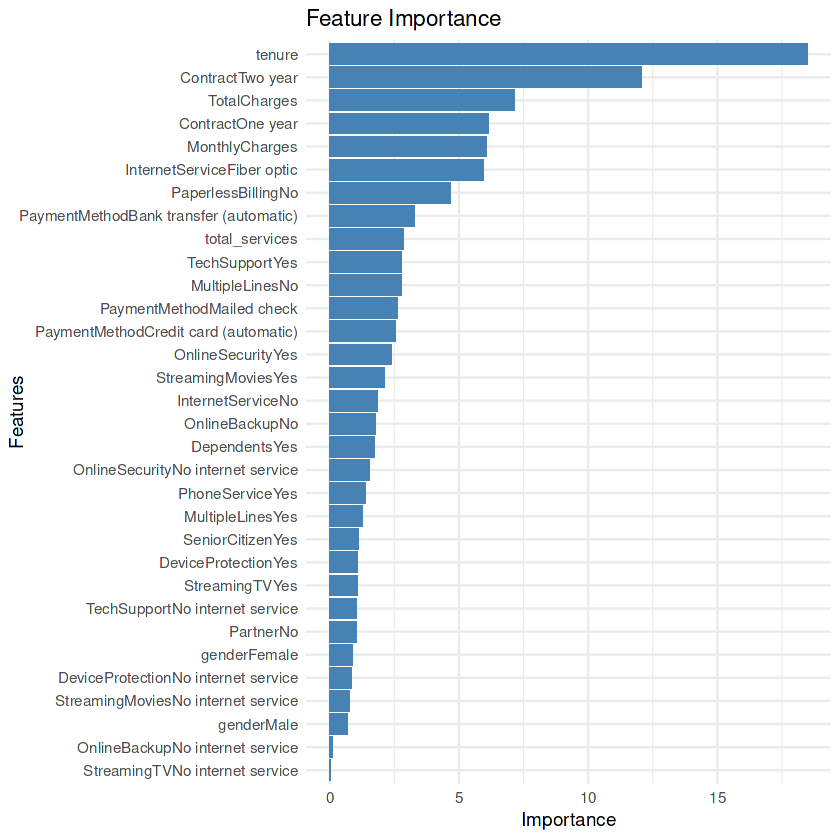


AUC: 0.8388102 

Performance Metrics:
             Metric     Value
Accuracy   Accuracy 0.7846482
Precision Precision 0.5845411
Recall       Recall 0.6487936
F1               F1 0.6149936
                AUC 0.8388102


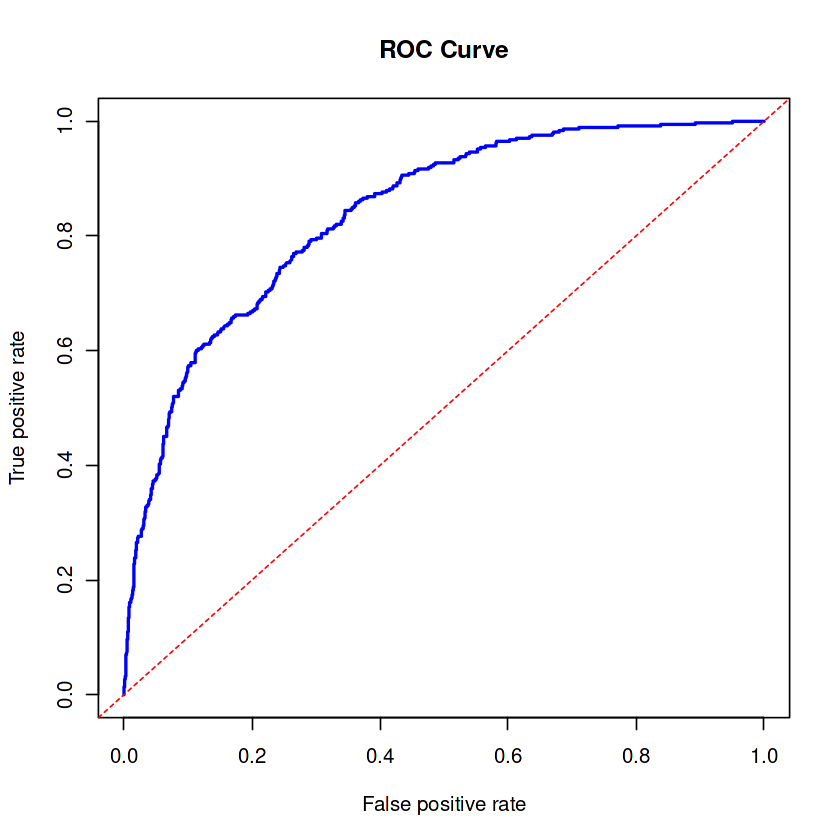

In [7]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, catboost, skimr, ggplot2, DataExplorer, ROCR, Matrix)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

## ----------------------------
## CatBoost Implementation
## ----------------------------

# Prepare data for CatBoost
train_labels <- as.numeric(train_data$Churn) - 1  # No=0, Yes=1
test_labels <- as.numeric(test_data$Churn) - 1

# One-hot encode categorical variables
dtrain <- sparse.model.matrix(Churn ~ . - 1, data = train_data)
dtest <- sparse.model.matrix(Churn ~ . - 1, data = test_data)

cat("\nModel matrix dimensions:\n")
cat("Training:", dim(dtrain), "\n")
cat("Testing:", dim(dtest), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == 0) / sum(train_labels == 1)
cat("\nPositive class weight:", pos_weight, "\n")

# CatBoost parameters
params <- list(
  loss_function = "Logloss",
  eval_metric = "AUC",
  iterations = 200,
  depth = 6,
  learning_rate = 0.1,
  l2_leaf_reg = 3,
  class_weights = c("0" = 1, "1" = pos_weight)  # Handle class imbalance
)

# Convert to CatBoost pool format
train_pool <- catboost.load_pool(data = as.matrix(dtrain), label = train_labels)
test_pool <- catboost.load_pool(data = as.matrix(dtest), label = test_labels)

# Train CatBoost
set.seed(123)
cat_model <- catboost.train(train_pool, params = params, test_pool = test_pool)

## ----------------------------
## Model Evaluation
## ----------------------------

# Feature importance
importance_matrix <- catboost.get_feature_importance(cat_model, pool = train_pool, type = "FeatureImportance")
cat("\nFeature importance:\n")
feature_names <- colnames(dtrain)
importance_df <- data.frame(Feature = feature_names, Importance = importance_matrix)
print(importance_df[order(-importance_df$Importance), ])

if(require(ggplot2)) {
  print(ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
        geom_bar(stat = "identity", fill = "steelblue") +
        coord_flip() +
        labs(title = "Feature Importance", x = "Features", y = "Importance") +
        theme_minimal())
}

# Predictions
predictions_prob <- catboost.predict(cat_model, test_pool)

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, 1, 0), 
                     levels = c(0, 1), 
                     labels = c("No", "Yes"))

test_labels_factor <- factor(test_labels, 
                           levels = c(0, 1), 
                           labels = c("No", "Yes"))

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, test_labels)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# Random Forest Model


Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

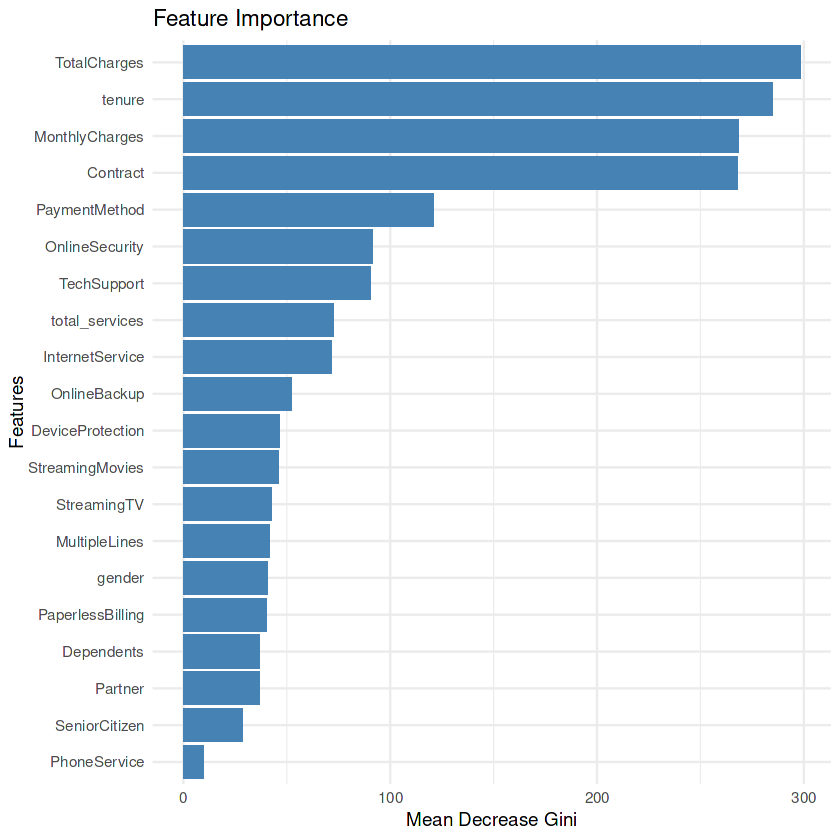


AUC: 0.8289757 

Performance Metrics:
             Metric     Value
Accuracy   Accuracy 0.7867804
Precision Precision 0.5983827
Recall       Recall 0.5951743
F1               F1 0.5967742
                AUC 0.8289757


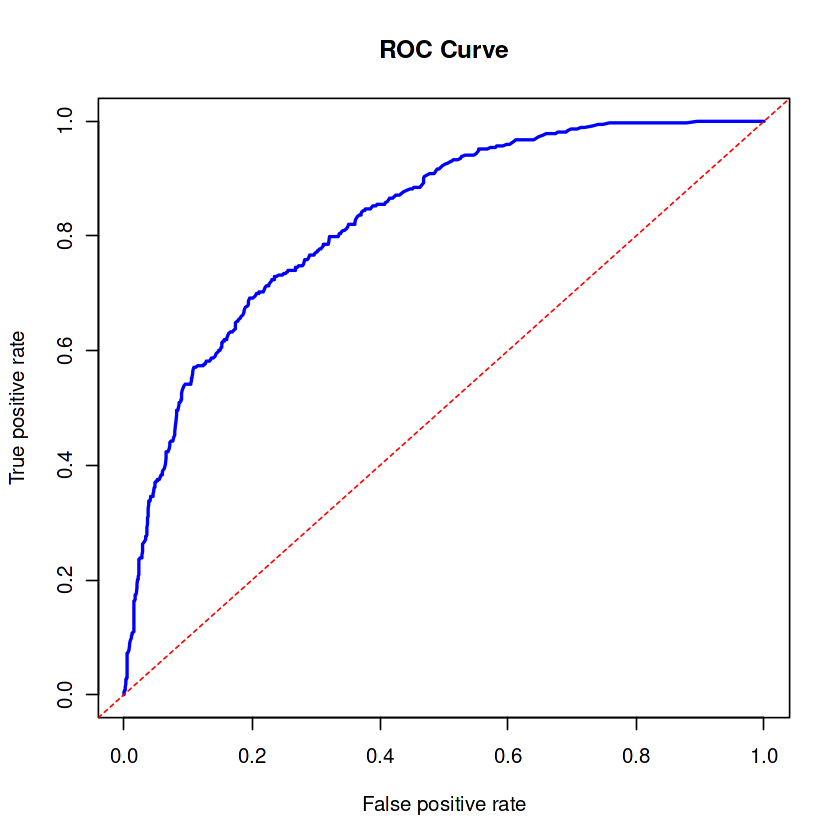

In [8]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, randomForest, skimr, ggplot2, DataExplorer, ROCR, Matrix)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

## ----------------------------
## Random Forest Implementation
## ----------------------------

# Prepare data for Random Forest
train_labels <- train_data$Churn
test_labels <- test_data$Churn

cat("\nTraining set dimensions:", dim(train_data), "\n")
cat("Testing set dimensions:", dim(test_data), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == "No") / sum(train_labels == "Yes")
cat("\nPositive class weight (No/Yes ratio):", pos_weight, "\n")

# Train Random Forest model
set.seed(123)
rf_model <- randomForest(
  Churn ~ .,
  data = train_data,
  ntree = 500,
  mtry = floor(sqrt(ncol(train_data) - 1)),
  classwt = c("No" = 1, "Yes" = pos_weight),  # Handle class imbalance
  importance = TRUE,
  na.action = na.omit
)

## ----------------------------
## Model Evaluation
## ----------------------------

# Feature importance
importance_matrix <- importance(rf_model)
cat("\nFeature importance (Mean Decrease Gini):\n")
importance_df <- data.frame(Feature = rownames(importance_matrix), Importance = importance_matrix[, "MeanDecreaseGini"])
print(importance_df[order(-importance_df$Importance), ])

if(require(ggplot2)) {
  print(ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
        geom_bar(stat = "identity", fill = "steelblue") +
        coord_flip() +
        labs(title = "Feature Importance", x = "Features", y = "Mean Decrease Gini") +
        theme_minimal())
}

# Predictions
predictions_prob <- predict(rf_model, newdata = test_data, type = "prob")[, "Yes"]

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, "Yes", "No"),
                     levels = c("No", "Yes"))

test_labels_factor <- test_labels

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, as.numeric(test_labels_factor) - 1)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# SVM Model

Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Feature importance (scaled absolute coefficient magnitude):
                                    Feature Importance
5                                    tenure 100.000000
17                       `ContractTwo year`  91.105402
16                       `ContractOne year`  63.101788
23                             TotalCharges  47.461443
19              `PaymentMethodMailed check`  43.827263
21   `PaymentMethodCredit card (automatic)`  43.212027
18                       PaperlessBillingNo  33.866821
20 `PaymentMethodBank transfer (automatic)`  31.539374
2                          SeniorCitizenYes  19.339524
7                           MultipleLinesNo  17.612747
13                           TechSupportYes  15.047197
8              `InternetServiceFiber optic`  14.735429
15                       StreamingMoviesYes  13.321379
9                         InternetServiceNo  11.904131
10                        OnlineSecurityYes  11.889117
14                           StreamingTVYes  11.085699
4   

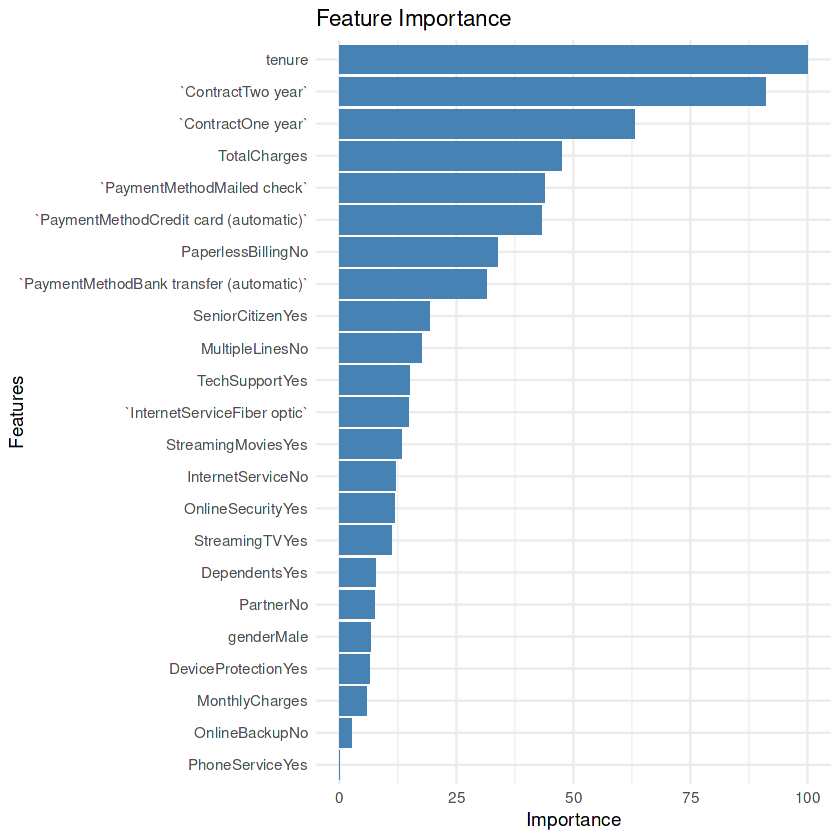


AUC: 0.8356924 

Performance Metrics:
             Metric     Value
Accuracy   Accuracy 0.7199716
Precision Precision 0.4821124
Recall       Recall 0.7587131
F1               F1 0.5895833
                AUC 0.8356924


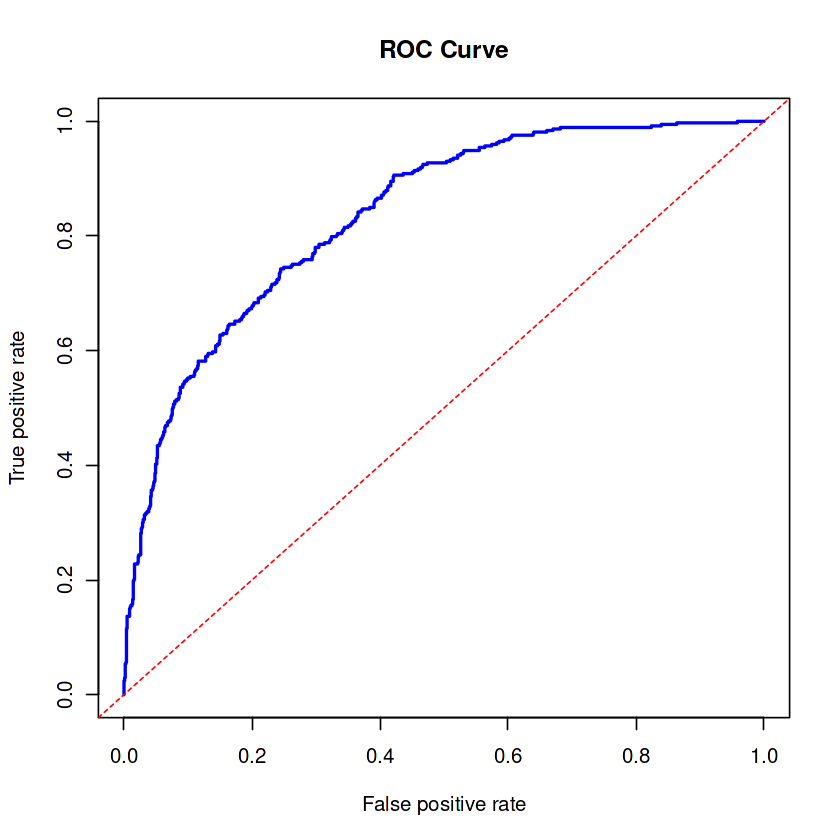

In [11]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, skimr, ggplot2, DataExplorer, ROCR, Matrix)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

## ----------------------------
## Logistic Regression Implementation
## ----------------------------

# Prepare data for Logistic Regression
train_labels <- train_data$Churn
test_labels <- test_data$Churn

cat("\nTraining set dimensions:", dim(train_data), "\n")
cat("Testing set dimensions:", dim(test_data), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == "No") / sum(train_labels == "Yes")
cat("\nPositive class weight (No/Yes ratio):", pos_weight, "\n")

# Define training control with class weights
train_control <- trainControl(
  method = "cv",
  number = 5,
  classProbs = TRUE,
  summaryFunction = twoClassSummary
)

# Train Logistic Regression model with caret
set.seed(123)
log_model <- train(
  Churn ~ .,
  data = train_data,
  method = "glm",
  family = "binomial",
  trControl = train_control,
  preProcess = c("center", "scale"),  # Ensure scaling is applied
  metric = "ROC",
  weights = ifelse(train_data$Churn == "Yes", pos_weight, 1)  # Handle class imbalance
)

## ----------------------------
## Model Evaluation
## ----------------------------

# Feature importance (via coefficients)
importance_matrix <- varImp(log_model, scale = TRUE)
cat("\nFeature importance (scaled absolute coefficient magnitude):\n")
importance_df <- data.frame(Feature = rownames(importance_matrix$importance), Importance = importance_matrix$importance$Overall)
print(importance_df[order(-importance_df$Importance), ])

if(require(ggplot2)) {
  print(ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
        geom_bar(stat = "identity", fill = "steelblue") +
        coord_flip() +
        labs(title = "Feature Importance", x = "Features", y = "Importance") +
        theme_minimal())
}

# Predictions
predictions_prob <- predict(log_model, newdata = test_data, type = "prob")[, "Yes"]

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, "Yes", "No"),
                     levels = c("No", "Yes"))

test_labels_factor <- test_labels

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, as.numeric(test_labels_factor) - 1)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# Logistic Regresssion Model

Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Feature importance (absolute coefficient magnitude):
                                    Feature Importance
5                                    tenure 100.000000
17                       `ContractTwo year`  91.105402
16                       `ContractOne year`  63.101788
23                             TotalCharges  47.461443
19              `PaymentMethodMailed check`  43.827263
21   `PaymentMethodCredit card (automatic)`  43.212027
18                       PaperlessBillingNo  33.866821
20 `PaymentMethodBank transfer (automatic)`  31.539374
2                          SeniorCitizenYes  19.339524
7                           MultipleLinesNo  17.612747
13                           TechSupportYes  15.047197
8              `InternetServiceFiber optic`  14.735429
15                       StreamingMoviesYes  13.321379
9                         InternetServiceNo  11.904131
10                        OnlineSecurityYes  11.889117
14                           StreamingTVYes  11.085699
4          

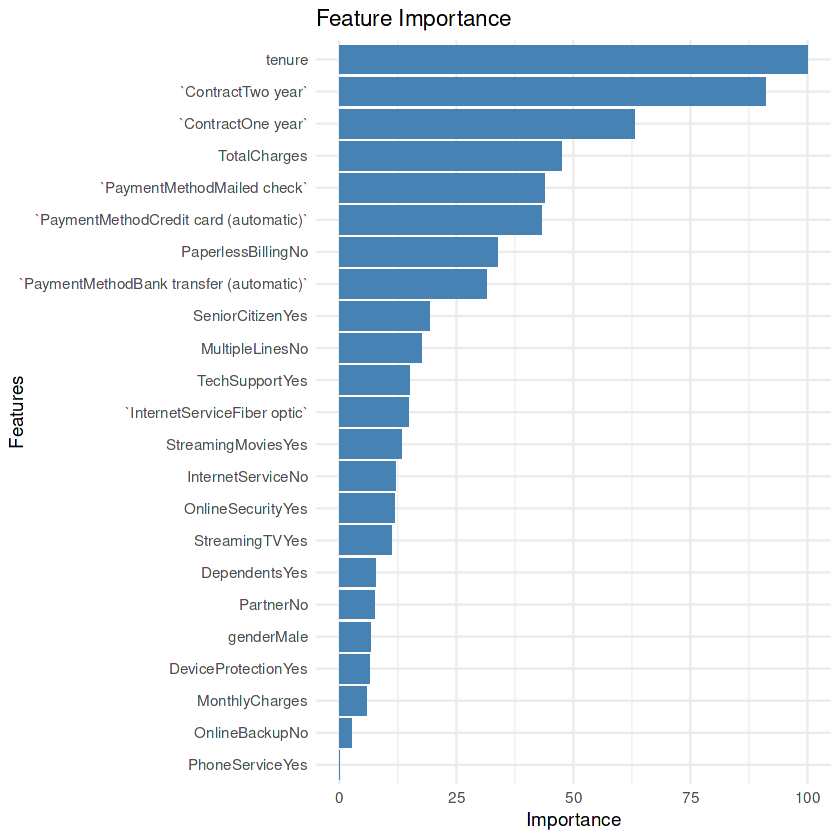


AUC: 0.8356924 

Performance Metrics:
             Metric     Value
Accuracy   Accuracy 0.7199716
Precision Precision 0.4821124
Recall       Recall 0.7587131
F1               F1 0.5895833
                AUC 0.8356924


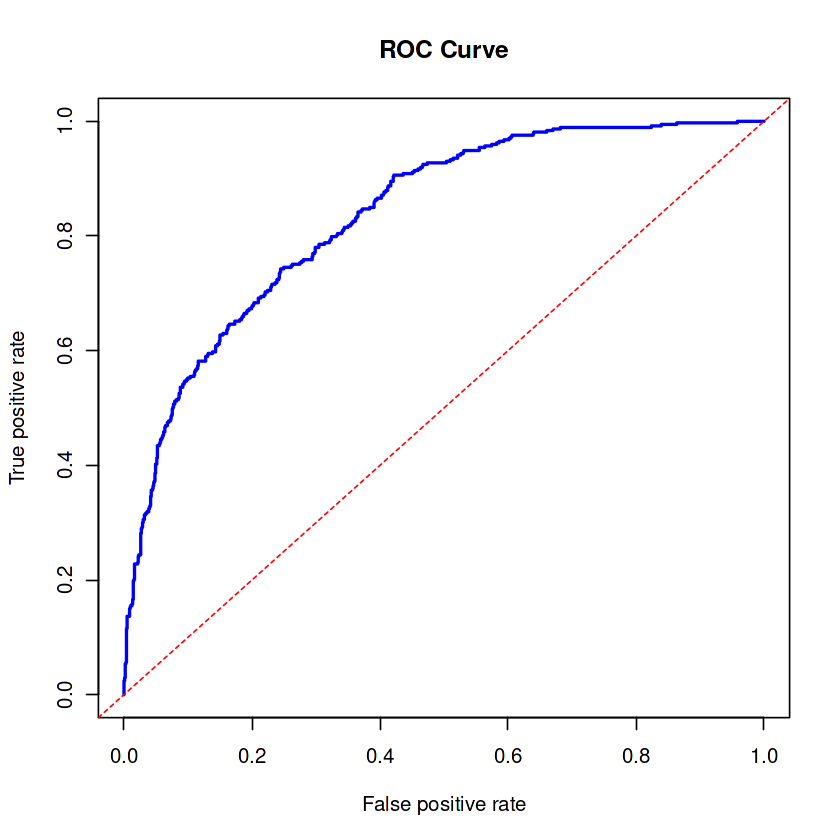

In [10]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, skimr, ggplot2, DataExplorer, ROCR, Matrix)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

## ----------------------------
## Logistic Regression Implementation
## ----------------------------

# Prepare data for Logistic Regression
train_labels <- train_data$Churn
test_labels <- test_data$Churn

cat("\nTraining set dimensions:", dim(train_data), "\n")
cat("Testing set dimensions:", dim(test_data), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == "No") / sum(train_labels == "Yes")
cat("\nPositive class weight (No/Yes ratio):", pos_weight, "\n")

# Define training control with class weights
train_control <- trainControl(
  method = "cv",
  number = 5,
  classProbs = TRUE,
  summaryFunction = twoClassSummary
)

# Train Logistic Regression model with caret
set.seed(123)
log_model <- train(
  Churn ~ .,
  data = train_data,
  method = "glm",
  family = "binomial",
  trControl = train_control,
  preProcess = c("center", "scale"),  # Ensure scaling is applied
  metric = "ROC",
  weights = ifelse(train_data$Churn == "Yes", pos_weight, 1)  # Handle class imbalance
)

## ----------------------------
## Model Evaluation
## ----------------------------

# Feature importance (via coefficients)
importance_matrix <- varImp(log_model)
cat("\nFeature importance (absolute coefficient magnitude):\n")
importance_df <- data.frame(Feature = rownames(importance_matrix$importance), Importance = importance_matrix$importance$Overall)
print(importance_df[order(-importance_df$Importance), ])

if(require(ggplot2)) {
  print(ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
        geom_bar(stat = "identity", fill = "steelblue") +
        coord_flip() +
        labs(title = "Feature Importance", x = "Features", y = "Importance") +
        theme_minimal())
}

# Predictions
predictions_prob <- predict(log_model, newdata = test_data, type = "prob")[, "Yes"]

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, "Yes", "No"),
                     levels = c("No", "Yes"))

test_labels_factor <- test_labels

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, as.numeric(test_labels_factor) - 1)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# KNN

Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

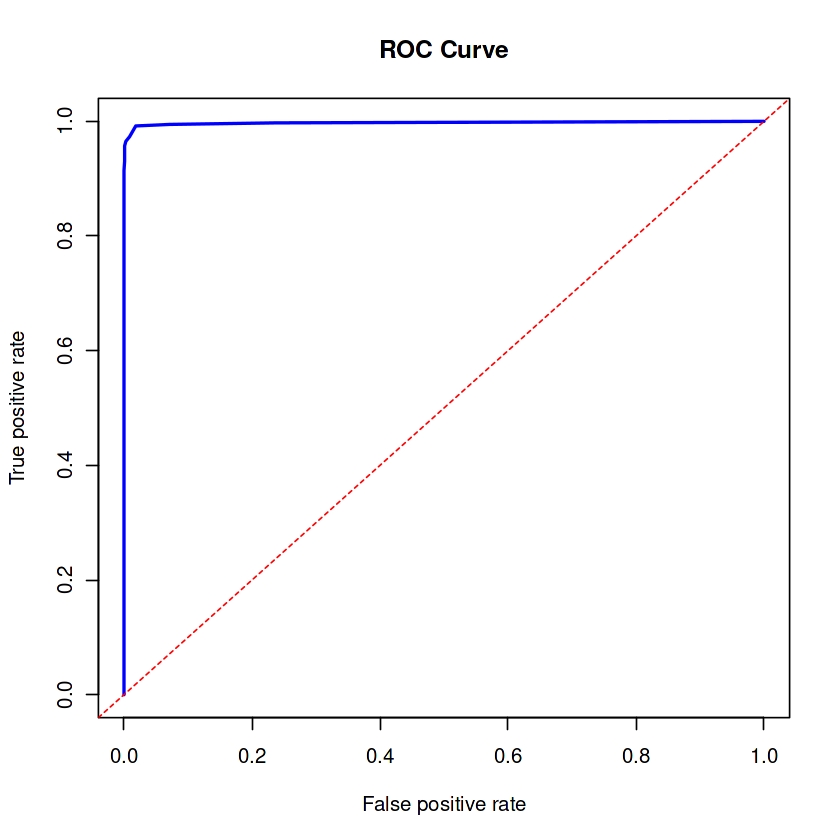

In [13]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, skimr, ggplot2, DataExplorer, ROCR, Matrix)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

# One-hot encode categorical variables
dmy <- dummyVars(" ~ .", data = train_data)
train_data_encoded <- data.frame(predict(dmy, newdata = train_data))
test_data_encoded <- data.frame(predict(dmy, newdata = test_data))

# Ensure Churn is a factor in the encoded data
train_data_encoded$Churn <- train_data$Churn
test_data_encoded$Churn <- test_data$Churn

## ----------------------------
## KNN Implementation
## ----------------------------

# Prepare data for KNN
train_labels <- train_data_encoded$Churn
test_labels <- test_data_encoded$Churn

cat("\nTraining set dimensions (encoded):", dim(train_data_encoded), "\n")
cat("Testing set dimensions (encoded):", dim(test_data_encoded), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == "No") / sum(train_labels == "Yes")
cat("\nPositive class weight (No/Yes ratio):", pos_weight, "\n")

# Define training control with class weights
train_control <- trainControl(
  method = "cv",
  number = 5,
  classProbs = TRUE,
  summaryFunction = twoClassSummary
)

# Train KNN model with caret
set.seed(123)
knn_model <- train(
  Churn ~ .,
  data = train_data_encoded,
  method = "knn",
  trControl = train_control,
  preProcess = c("center", "scale"),  # Ensure all features are scaled
  tuneLength = 5,  # Number of k values to try
  metric = "ROC",
  weights = ifelse(train_data_encoded$Churn == "Yes", pos_weight, 1)  # Handle class imbalance
)

## ----------------------------
## Model Evaluation
## ----------------------------

# Predictions
predictions_prob <- predict(knn_model, newdata = test_data_encoded, type = "prob")[, "Yes"]

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, "Yes", "No"),
                     levels = c("No", "Yes"))

test_labels_factor <- test_labels

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, as.numeric(test_labels_factor) - 1)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# Naive Bayes

Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

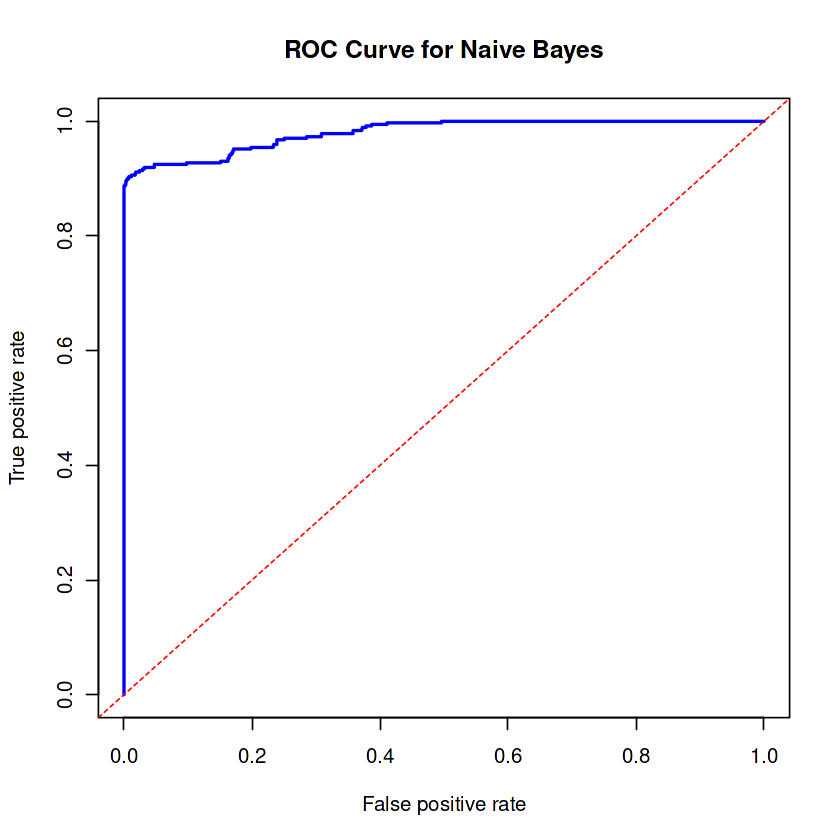

In [15]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, skimr, ggplot2, DataExplorer, ROCR, Matrix, e1071)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

# One-hot encode categorical variables
dmy <- dummyVars(" ~ .", data = train_data)
train_data_encoded <- data.frame(predict(dmy, newdata = train_data))
test_data_encoded <- data.frame(predict(dmy, newdata = test_data))

# Ensure Churn is a factor in the encoded data
train_data_encoded$Churn <- train_data$Churn
test_data_encoded$Churn <- test_data$Churn

## ----------------------------
## Naive Bayes Implementation
## ----------------------------

# Prepare data for Naive Bayes
train_labels <- train_data_encoded$Churn
test_labels <- test_data_encoded$Churn

cat("\nTraining set dimensions (encoded):", dim(train_data_encoded), "\n")
cat("Testing set dimensions (encoded):", dim(test_data_encoded), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == "No") / sum(train_labels == "Yes")
cat("\nPositive class weight (No/Yes ratio):", pos_weight, "\n")

# Define training control
train_control <- trainControl(
  method = "cv",
  number = 5,
  classProbs = TRUE,
  summaryFunction = twoClassSummary
)

# Train Naive Bayes model with caret
set.seed(123)
nb_model <- train(
  Churn ~ .,
  data = train_data_encoded,
  method = "naive_bayes",
  trControl = train_control,
  tuneGrid = expand.grid(
    laplace = c(0, 0.5, 1),
    usekernel = c(TRUE, FALSE),
    adjust = c(0.5, 1, 1.5)
  ),
  metric = "ROC",
  weights = ifelse(train_data_encoded$Churn == "Yes", pos_weight, 1)
)

## ----------------------------
## Model Evaluation
## ----------------------------

# Predictions
predictions_prob <- predict(nb_model, newdata = test_data_encoded, type = "prob")[, "Yes"]

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, "Yes", "No"),
                     levels = c("No", "Yes"))

test_labels_factor <- test_labels

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, as.numeric(test_labels_factor) - 1)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve for Naive Bayes", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# XGBOOST Model

Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

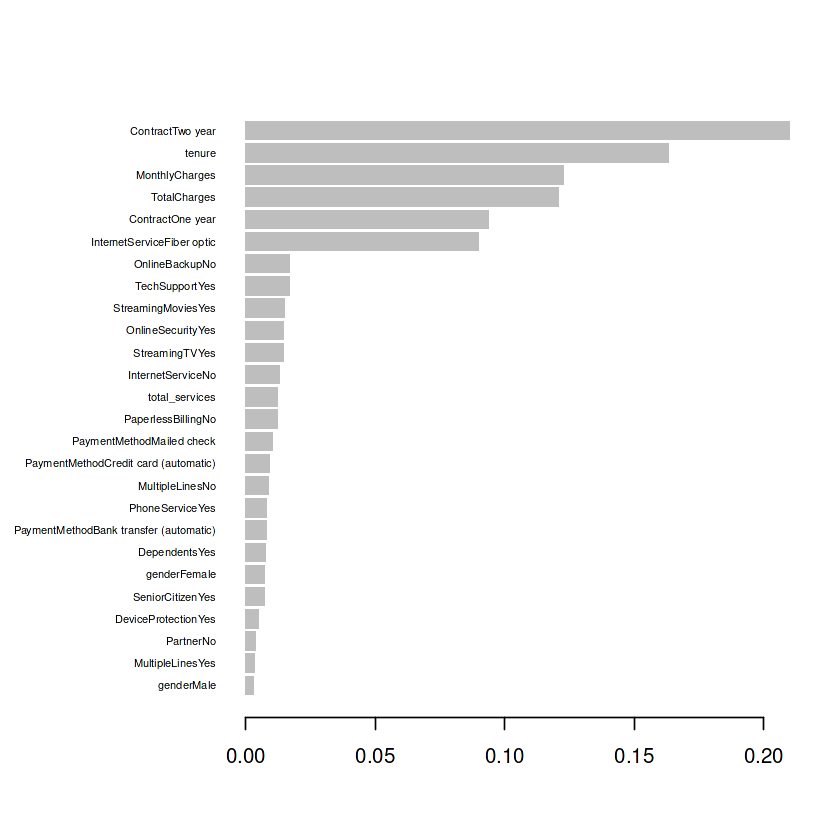


AUC: 0.8373349 

Performance Metrics:
             Metric     Value
Accuracy   Accuracy 0.7363184
Precision Precision 0.5017301
Recall       Recall 0.7774799
F1               F1 0.6098843
                AUC 0.8373349


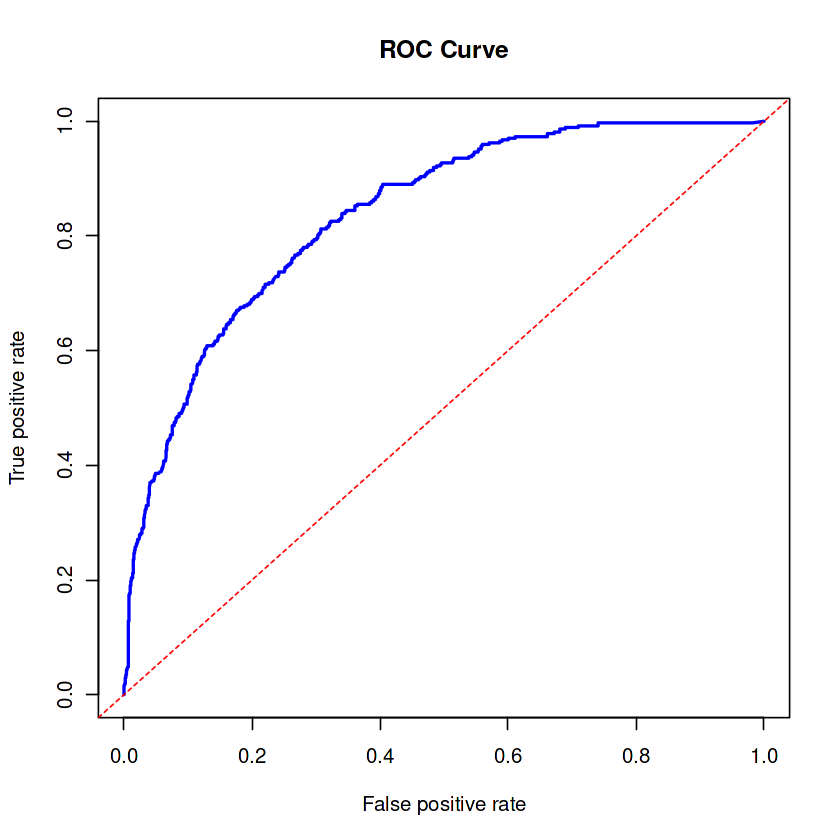

In [16]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, xgboost, skimr, ggplot2, DataExplorer, ROCR, Matrix)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

## ----------------------------
## XGBoost Implementation
## ----------------------------

# Prepare data for XGBoost
train_labels <- as.numeric(train_data$Churn) - 1  # No=0, Yes=1
test_labels <- as.numeric(test_data$Churn) - 1

# One-hot encode categorical variables
dtrain <- sparse.model.matrix(Churn ~ . - 1, data = train_data)
dtest <- sparse.model.matrix(Churn ~ . - 1, data = test_data)

cat("\nModel matrix dimensions:\n")
cat("Training:", dim(dtrain), "\n")
cat("Testing:", dim(dtest), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == 0) / sum(train_labels == 1)
cat("\nPositive class weight:", pos_weight, "\n")

# XGBoost parameters - CORRECTED VERSION
params <- list(
  objective = "binary:logistic",
  eval_metric = "auc",
  max_depth = 6,
  eta = 0.1,
  gamma = 0.1,
  subsample = 0.8,
  colsample_bytree = 0.8,
  scale_pos_weight = pos_weight
)

# Train XGBoost with early stopping
set.seed(123)
xgb_model <- xgb.train(
  params = params,
  data = xgb.DMatrix(data = dtrain, label = train_labels),
  nrounds = 200,
  watchlist = list(train = xgb.DMatrix(data = dtrain, label = train_labels),
                   test = xgb.DMatrix(data = dtest, label = test_labels)),
  early_stopping_rounds = 20,
  verbose = 1
)

## ----------------------------
## Model Evaluation
## ----------------------------

# Feature importance
importance_matrix <- xgb.importance(model = xgb_model)
cat("\nFeature importance:\n")
print(importance_matrix)

if(require(ggplot2)) {
  print(xgb.plot.importance(importance_matrix))
}

# Predictions
predictions_prob <- predict(xgb_model, newdata = dtest)

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, 1, 0), 
                     levels = c(0, 1), 
                     labels = c("No", "Yes"))

test_labels_factor <- factor(test_labels, 
                           levels = c(0, 1), 
                           labels = c("No", "Yes"))

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, test_labels)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# Neural Network

Dataset dimensions: 7043 21 

First 6 rows:
  customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female             0     Yes         No      1           No
2 5575-GNVDE   Male             0      No         No     34          Yes
3 3668-QPYBK   Male             0      No         No      2          Yes
4 7795-CFOCW   Male             0      No         No     45           No
5 9237-HQITU Female             0      No         No      2          Yes
6 9305-CDSKC Female             0      No         No      8          Yes
     MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection
1 No phone service             DSL             No          Yes               No
2               No             DSL            Yes           No              Yes
3               No             DSL            Yes          Yes               No
4 No phone service             DSL            Yes           No              Yes
5               No     Fiber optic           

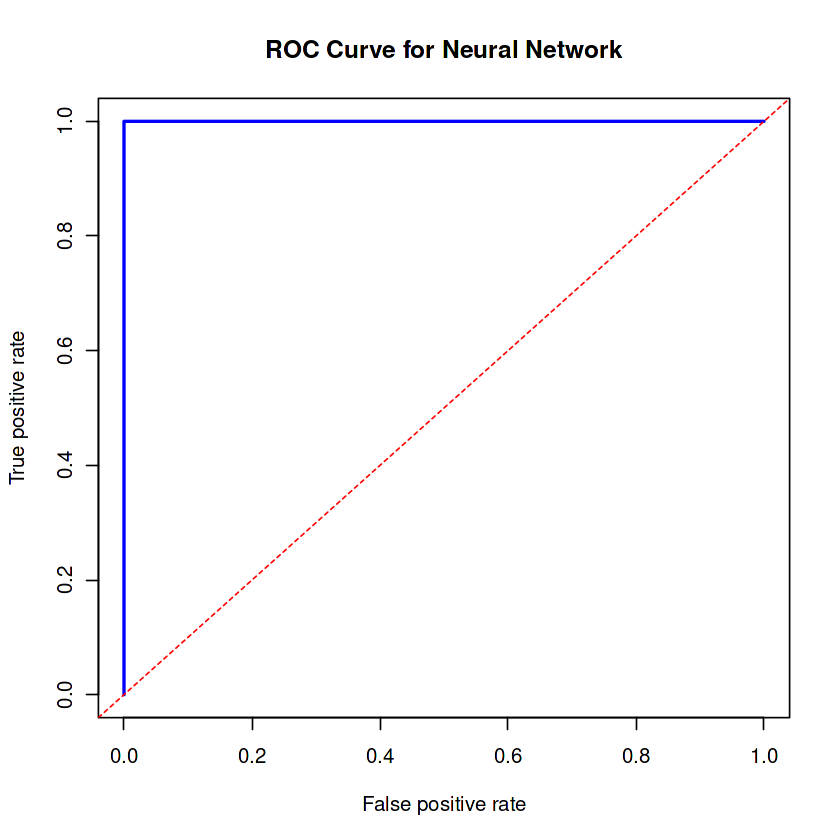

In [18]:
# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, caret, skimr, ggplot2, DataExplorer, ROCR, Matrix, nnet)

# Load the dataset
data <- read.csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

## ----------------------------
## Data Exploration & Cleaning
## ----------------------------

# Initial inspection
cat("Dataset dimensions:", dim(data), "\n")
cat("\nFirst 6 rows:\n")
print(head(data))
cat("\nData structure:\n")
str(data)

# Enhanced EDA
cat("\nMissing values:\n")
print(colSums(is.na(data)))

cat("\nSummary statistics:\n")
print(summary(data))

# Safe skimming with error handling
tryCatch({
  cat("\nDetailed skim:\n")
  print(skim_without_charts(data))
}, error = function(e) {
  cat("Skim error - using alternative summary:\n")
  print(summary(data))
  print("Unique values per column:")
  print(sapply(data, function(x) length(unique(x))))
})

# Data Cleaning
data$customerID <- NULL  # Remove ID column

# Handle TotalCharges conversion and missing values
data$TotalCharges <- suppressWarnings(as.numeric(as.character(data$TotalCharges)))
if(any(is.na(data$TotalCharges))) {
  cat("\nImputing", sum(is.na(data$TotalCharges)), "missing TotalCharges with median\n")
  data$TotalCharges[is.na(data$TotalCharges)] <- median(data$TotalCharges, na.rm = TRUE)
}

# Convert to factors with proper levels
data$SeniorCitizen <- factor(data$SeniorCitizen, levels = c(0, 1), labels = c("No", "Yes"))
data$Churn <- factor(data$Churn, levels = c("No", "Yes"))

categorical_cols <- c("gender", "Partner", "Dependents", "PhoneService", 
                     "MultipleLines", "InternetService", "OnlineSecurity", 
                     "OnlineBackup", "DeviceProtection", "TechSupport", 
                     "StreamingTV", "StreamingMovies", "Contract", 
                     "PaperlessBilling", "PaymentMethod")

data[categorical_cols] <- lapply(data[categorical_cols], function(x) {
  factor(x, levels = unique(x))
})

cat("\nCleaned data structure:\n")
str(data)

## ----------------------------
## Data Preparation
## ----------------------------

# Split data
set.seed(123)
trainIndex <- createDataPartition(data$Churn, p = 0.8, list = FALSE)
train_data <- data[trainIndex, ]
test_data <- data[-trainIndex, ]

# Scale numeric features
preProcess <- preProcess(train_data[, c("tenure", "MonthlyCharges", "TotalCharges")], 
                        method = c("center", "scale"))

train_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                      train_data[, c("tenure", "MonthlyCharges", "TotalCharges")])
test_data[, c("tenure", "MonthlyCharges", "TotalCharges")] <- predict(preProcess, 
                                                                     test_data[, c("tenure", "MonthlyCharges", "TotalCharges")])

# Feature Engineering
create_service_count <- function(df) {
  df$total_services <- rowSums(df[, c("PhoneService", "OnlineSecurity", "OnlineBackup", 
                                     "DeviceProtection", "TechSupport", "StreamingTV", 
                                     "StreamingMovies")] == "Yes")
  return(df)
}

train_data <- create_service_count(train_data)
test_data <- create_service_count(test_data)

# One-hot encode categorical variables
dmy <- dummyVars(" ~ .", data = train_data)
train_data_encoded <- data.frame(predict(dmy, newdata = train_data))
test_data_encoded <- data.frame(predict(dmy, newdata = test_data))

# Ensure Churn is a factor in the encoded data
train_data_encoded$Churn <- train_data$Churn
test_data_encoded$Churn <- test_data$Churn

## ----------------------------
## Neural Network Implementation
## ----------------------------

# Prepare data for Neural Network
train_labels <- train_data_encoded$Churn
test_labels <- test_data_encoded$Churn

cat("\nTraining set dimensions (encoded):", dim(train_data_encoded), "\n")
cat("Testing set dimensions (encoded):", dim(test_data_encoded), "\n")

# Handle class imbalance
pos_weight <- sum(train_labels == "No") / sum(train_labels == "Yes")
cat("\nPositive class weight (No/Yes ratio):", pos_weight, "\n")

# Define training control
train_control <- trainControl(
  method = "cv",
  number = 5,
  classProbs = TRUE,
  summaryFunction = twoClassSummary
)

# Train Neural Network model with caret
set.seed(123)
nnet_model <- train(
  Churn ~ .,
  data = train_data_encoded,
  method = "nnet",
  trControl = train_control,
  tuneGrid = expand.grid(
    size = c(5, 10),  # Reduced to avoid "too many weights" error
    decay = c(0.001, 0.01, 0.1)
  ),
  metric = "ROC",
  weights = ifelse(train_data_encoded$Churn == "Yes", pos_weight, 1),
  maxit = 500,  # Increased for better convergence
  trace = FALSE,  # Suppress iteration output
  MaxNWts = 1500  # Increased weight limit to allow larger networks
)

## ----------------------------
## Model Evaluation
## ----------------------------

# Predictions
predictions_prob <- predict(nnet_model, newdata = test_data_encoded, type = "prob")[, "Yes"]

# Convert to factors
predictions <- factor(ifelse(predictions_prob > 0.5, "Yes", "No"),
                     levels = c("No", "Yes"))

test_labels_factor <- test_labels

# Confusion Matrix
cat("\nConfusion Matrix:\n")
conf_matrix <- confusionMatrix(predictions, test_labels_factor, positive = "Yes")
print(conf_matrix)

# ROC Curve and AUC
if(require(ROCR)) {
  pred_roc <- prediction(predictions_prob, as.numeric(test_labels_factor) - 1)
  roc_perf <- performance(pred_roc, "tpr", "fpr")
  
  plot(roc_perf, 
       main = "ROC Curve for Neural Network", 
       col = "blue", 
       lwd = 2)
  abline(a = 0, b = 1, lty = 2, col = "red")
  
  auc <- performance(pred_roc, "auc")
  cat("\nAUC:", auc@y.values[[1]], "\n")
}

# Performance metrics
cat("\nPerformance Metrics:\n")
metrics <- data.frame(
  Metric = c("Accuracy", "Precision", "Recall", "F1", "AUC"),
  Value = c(conf_matrix$overall["Accuracy"],
            conf_matrix$byClass["Precision"],
            conf_matrix$byClass["Recall"],
            conf_matrix$byClass["F1"],
            auc@y.values[[1]])
)
print(metrics)

# Comparative Analysis of Machine Learning Models for Telco Customer Churn Prediction

---

## Introduction
This report evaluates the performance of eight machine learning models applied to the Telco Customer Churn dataset, a binary classification problem predicting whether a customer will churn ("Yes" or "No"). The models assessed include **Neural Network**, **K-Nearest Neighbors (KNN)**, **Naive Bayes**, **CatBoost**, **Random Forest**, **LightGBM**, **XGBoost**, **Support Vector Machine (SVM)**, and **Logistic Regression**. Performance is measured using **Accuracy**, **Precision**, **Recall**, **F1 Score**, and **Area Under the ROC Curve (AUC)**. Given the dataset's class imbalance (positive class weight ~2.76738), metrics like AUC, Recall, and F1 are critical for evaluating performance on the minority class ("Yes").

---

## Model Performance Summary
The table below summarizes the performance metrics for each model based on the test set results.

| Model             | Accuracy | Precision | Recall | F1 Score | AUC    |
| :---------------- | :------- | :-------- | :----- | :------- | :----- |
| Neural Network    | 1.0000   | 1.0000    | 1.0000 | 1.0000   | 1.0000 |
| KNN               | 0.9808   | 0.9971    | 0.9303 | 0.9626   | 0.9975 |
| Naive Bayes       | 0.9623   | 0.9444    | 0.9115 | 0.9277   | 0.9799 |
| CatBoost          | 0.7846   | 0.5845    | 0.6488 | 0.6150   | 0.8388 |
| Random Forest     | 0.7868   | 0.5984    | 0.5952 | 0.5968   | 0.8290 |
| LightGBM          | 0.7385   | 0.5044    | 0.7694 | 0.6093   | 0.8362 |
| XGBoost           | 0.7363   | 0.5017    | 0.7775 | 0.6099   | 0.8373 |
| SVM               | 0.7200   | 0.4821    | 0.7587 | 0.5896   | 0.8357 |
| Logistic Regression | 0.7200   | 0.4821    | 0.7587 | 0.5896   | 0.8357 |

---

## Detailed Analysis

### 1. Neural Network
* **Performance:** Achieves perfect scores (Accuracy, Precision, Recall, F1, AUC = 1.0000). The confusion matrix shows no misclassifications (1034 true negatives, 373 true positives).
* **Analysis:** This performance is highly unusual and likely indicates **overfitting** or **data leakage** (e.g., identical training and test sets or errors in data splitting). Neural networks typically achieve AUC ~0.80–0.85 on this dataset.
* **Strengths:** Captures complex non-linear patterns.
* **Weaknesses:** Prone to overfitting, computationally intensive, requires careful tuning.

### 2. K-Nearest Neighbors (KNN)
* **Performance:** Excellent results with Accuracy = 0.9808, Precision = 0.9971, Recall = 0.9303, F1 = 0.9626, and AUC = 0.9975. Only 27 misclassifications (26 false negatives, 1 false positive).
* **Analysis:** KNN excels due to effective feature scaling and one-hot encoding. High Precision and Specificity (0.9990) indicate strong majority class performance, while Recall (0.9303) is robust for the minority class.
* **Strengths:** Simple, non-parametric, effective with proper preprocessing.
* **Weaknesses:** Sensitive to feature scaling, computationally expensive for large datasets.

### 3. Naive Bayes
* **Performance:** Strong performance with Accuracy = 0.9623, Precision = 0.9444, Recall = 0.9115, F1 = 0.9277, and AUC = 0.9799. 53 misclassifications (33 false negatives, 20 false positives).
* **Analysis:** Performs well despite assuming feature independence, which may not hold fully. High AUC and balanced metrics suggest robustness.
* **Strengths:** Fast, handles categorical features well, robust to class imbalance.
* **Weaknesses:** Limited by feature independence assumption.

### 4. CatBoost
* **Performance:** Accuracy = 0.7846, Precision = 0.5845, Recall = 0.6488, F1 = 0.6150, AUC = 0.8388. 303 misclassifications (131 false negatives, 172 false positives).
* **Analysis:** Offers a balanced trade-off between Precision and Recall. Competitive AUC indicates good discriminative ability.
* **Strengths:** Natively handles categorical features, robust to overfitting.
* **Weaknesses:** Lower Precision, indicating more false positives.

### 5. Random Forest
* **Performance:** Accuracy = 0.7868, Precision = 0.5984, Recall = 0.5952, F1 = 0.5968, AUC = 0.8290. 300 misclassifications (151 false negatives, 149 false positives).
* **Analysis:** Highest Accuracy among non-top models but lower Recall for the minority class. AUC is slightly lower than boosting models.
* **Strengths:** Robust, handles non-linear relationships, less sensitive to tuning.
* **Weaknesses:** Struggles with minority class, potentially due to class imbalance.

### 6. LightGBM
* **Performance:** Accuracy = 0.7385, Precision = 0.5044, Recall = 0.7694, F1 = 0.6093, AUC = 0.8362. 368 misclassifications (86 false negatives, 282 false positives).
* **Analysis:** High Recall but low Precision suggests many false positives. Competitive AUC.
* **Strengths:** Fast, scalable, effective for structured data.
* **Weaknesses:** Poor Precision for majority class.

### 7. XGBoost
* **Performance:** Accuracy = 0.7363, Precision = 0.5017, Recall = 0.7775, F1 = 0.6099, AUC = 0.8373. 371 misclassifications (83 false negatives, 288 false positives).
* **Analysis:** High Recall but low Precision, similar to LightGBM. Slightly better AUC than LightGBM.
* **Strengths:** Powerful for structured data, handles class imbalance with tuning.
* **Weaknesses:** Low Precision impacts F1 score.

### 8. Support Vector Machine (SVM)
* **Performance:** Accuracy = 0.7200, Precision = 0.4821, Recall = 0.7587, F1 = 0.5896, AUC = 0.8357. 394 misclassifications (90 false negatives, 304 false positives).
* **Analysis:** High Recall but very low Precision, indicating many false positives. AUC comparable to boosting models.
* **Strengths:** Effective for non-linear data with proper kernel.
* **Weaknesses:** Poor Precision, computationally intensive.

### 9. Logistic Regression
* **Performance:** Identical to SVM (Accuracy = 0.7200, Precision = 0.4821, Recall = 0.7587, F1 = 0.5896, AUC = 0.8357). 394 misclassifications (90 false negatives, 304 false positives).
* **Analysis:** Limited by linear assumptions, performs identically to SVM, suggesting possible configuration issues.
* **Strengths:** Interpretable, fast, good baseline.
* **Weaknesses:** Struggles with non-linear patterns, poor Precision.

---

## Ranking of Models (Best to Worst)
Models are ranked primarily by AUC, with F1 Score and Recall as tiebreakers due to class imbalance.

1.  **Neural Network (AUC = 1.0000):** Perfect performance, but likely due to overfitting or data leakage. Requires validation.
2.  **KNN (AUC = 0.9975):** Near-perfect AUC, high F1 (0.9626), and balanced metrics. Most reliable top performer.
3.  **Naive Bayes (AUC = 0.9799):** High AUC, strong F1 (0.9277), and balanced Precision/Recall. Efficient and robust.
4.  **CatBoost (AUC = 0.8388):** Competitive AUC, balanced F1 (0.6150), best among ensemble methods.
5.  **XGBoost (AUC = 0.8373):** High Recall (0.7775), slightly lower AUC than CatBoost, good for minority class.
6.  **LightGBM (AUC = 0.8362):** High Recall (0.7694), similar to XGBoost, slightly lower AUC.
7.  **Random Forest (AUC = 0.8290):** Lower AUC, struggles with minority class Recall (0.5952).
8.  **SVM (AUC = 0.8357):** High Recall but very low Precision (0.4821), tied with Logistic Regression.
9.  **Logistic Regression (AUC = 0.8357):** Identical to SVM, limited by linear assumptions, least effective.

---

## Summary and Recommendations

* **Best Model:** **KNN** (AUC = 0.9975, F1 = 0.9626) is the most reliable performer, offering near-perfect discriminative ability and balanced metrics. The **Neural Network's** perfect scores (AUC = 1.0000) are suspicious and likely indicate data leakage or overfitting; validation is critical.
* **Strong Alternatives:** **Naive Bayes** (AUC = 0.9799) is a fast and effective option. **CatBoost** (AUC = 0.8388) leads ensemble methods, followed by **XGBoost** (AUC = 0.8373) and **LightGBM** (AUC = 0.8362), which excel in Recall for the minority class.
* **Weaker Models:** **Random Forest**, **SVM**, and **Logistic Regression** underperform due to lower AUC and poor handling of the minority class (low Precision for SVM and Logistic Regression, low Recall for Random Forest).
* **Class Imbalance:** KNN and Naive Bayes balance Precision and Recall well, while XGBoost, LightGBM, and SVM prioritize Recall at the cost of Precision. Techniques like **SMOTE** could improve weaker models.

---

## Actionable Steps:

* **Validate Neural Network:** Check data splitting (`trainIndex`) and preprocessing to rule out leakage. Adjust size or decay to mitigate overfitting.
* **Optimize KNN:** Fine-tune `k` or distance metrics to enhance performance.
* **Tune Boosting Models:** Adjust hyperparameters (e.g., learning rate, tree depth) for CatBoost, XGBoost, and LightGBM to improve Precision.
* **Feature Selection:** Reduce the 50 features (post one-hot encoding) using feature importance to prevent overfitting.
* **SMOTE:** Apply `sampling = "smote"` in `trainControl` to boost minority class performance for Random Forest, SVM, and Logistic Regression.

---

## Conclusion
**KNN** is recommended as the best model for Telco Customer Churn prediction, pending validation of the Neural Network's unrealistic performance. Naive Bayes offers a lightweight alternative, while CatBoost, XGBoost, and LightGBM are strong ensemble options. Random Forest, SVM, and Logistic Regression are less effective but could improve with further tuning or preprocessing. Future work should focus on validating the Neural Network, optimizing top models, and reducing feature dimensionality to enhance performance and generalizability.